In [1]:
!pip3 install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=2498dd7aedb8a029a00bd7ab8b39dc940d862ebf02e1eff2b6bf1451aa716349
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import random
from collections import Counter, defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras.models import load_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import re
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras import regularizers

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd '/content/gdrive/MyDrive'

/content/gdrive/MyDrive


In [6]:
%cd 'mimic-iii-clinical-database-1.4'
%ls

/content/gdrive/MyDrive/mimic-iii-clinical-database-1.4
ADMISSIONS.csv.gz          DIAGNOSES_ICD.csv.gz     LICENSE.txt
CAREGIVERS.csv.gz          D_ICD_DIAGNOSES.csv.gz   NOTEEVENTS.csv.gz
CHARTEVENTS.csv.gz         D_ICD_PROCEDURES.csv.gz  PATIENTS.csv.gz
checksum_md5_unzipped.txt  D_ITEMS.csv.gz           PRESCRIPTIONS.csv.gz
checksum_md5_zipped.txt    D_LABITEMS.csv.gz        README.md
claims_codes_hs_300.txt    glove.6B.100d.txt        SERVICES.csv.gz
corpus.txt                 glove.6B.200d.txt        SHA256SUMS.txt
CPTEVENTS.csv.gz           glove.6B.300d.txt        vectors.txt
DATETIMEEVENTS.csv.gz      glove.6B.50d.txt
D_CPT.csv.gz               ICUSTAYS.csv.gz


In [7]:
import pandas as pd
import os
fn = 'NOTEEVENTS.csv.gz'
df = pd.read_csv(fn, compression='gzip')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


Data Cleaning

In [8]:
fn = 'DIAGNOSES_ICD.csv.gz'
df_two = pd.read_csv(fn, compression='gzip')
df_two.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [9]:
from pandasql import sqldf
q1 = """SELECT HADM_ID, max(SUBJECT_ID) SUBJECT_ID,  group_concat(ICD9_CODE, ' ') ICD9_CODE 
FROM df_two where ICD9_CODE IN (select ICD9_CODE from (select ICD9_CODE, COUNT(DISTINCT SUBJECT_ID) subjects_qty 
from df_two where substr(ICD9_CODE,1,1) != 'V' 
group by icd9_code order by subjects_qty desc limit 20) as icd9_subject_list)
group by hadm_id;"""
df_new_three = sqldf(q1)
df_new_three.head()

,HADM_ID,SUBJECT_ID,ICD9_CODE
0,100001,58526,5849
1,100003,54610,2851 4019
2,100006,9895,51881 486
3,100007,23018,486 4019
4,100009,533,41401 25000 2859 4019 2720


In [10]:
q3 = """SELECT HADM_ID, CHARTDATE, TEXT
from df where CATEGORY = 'Discharge summary' and DESCRIPTION = 'Report';"""
df_new_four = sqldf(q3)
df_new_four.head()

,HADM_ID,CHARTDATE,TEXT
0,167853.0,2151-08-04,Admission Date: [**2151-7-16**] Dischar...
1,107527.0,2118-06-14,Admission Date: [**2118-6-2**] Discharg...
2,167118.0,2119-05-25,Admission Date: [**2119-5-4**] D...
3,196489.0,2124-08-18,Admission Date: [**2124-7-21**] ...
4,135453.0,2162-03-25,Admission Date: [**2162-3-3**] D...


In [11]:
df_latest = pd.merge(left = df_new_four, right = df_new_three, on='HADM_ID', how = 'right')
df_latest = df_latest.dropna(subset=['CHARTDATE', 'TEXT'])
df_latest.head(40)

,HADM_ID,CHARTDATE,TEXT,SUBJECT_ID,ICD9_CODE
0,100001.0,2117-09-17,Admission Date: [**2117-9-11**] ...,58526,5849
1,100003.0,2150-04-21,Admission Date: [**2150-4-17**] ...,54610,2851 4019
2,100006.0,2108-04-17,Admission Date: [**2108-4-6**] Discharg...,9895,51881 486
3,100007.0,2145-04-07,Admission Date: [**2145-3-31**] ...,23018,486 4019
4,100009.0,2162-05-21,Admission Date: [**2162-5-16**] ...,533,41401 25000 2859 4019 2720
5,100011.0,2177-09-12,Admission Date: [**2177-8-29**] ...,87977,2851
6,100012.0,2177-03-22,Admission Date: [**2177-3-12**] ...,60039,41401 4019 2720
7,100016.0,2188-05-30,Admission Date: [**2188-5-24**] ...,68591,5070 51881
9,100018.0,2176-09-06,Admission Date: [**2176-8-29**] ...,58128,4280 42731 41401 496
10,100020.0,2142-12-10,Admission Date: [**2142-11-30**] ...,9973,5990 5849 4280 4019 53081


In [12]:
print('Full shape: ', df_latest.shape)
# taking just a subset of the records for developing models
df_pre = df_latest.sample(frac=0.1).reset_index(drop=True)
print('Subset shape: ', df_pre.shape)
df_pre.head(40)

Full shape:  (45837, 5)
Subset shape:  (4584, 5)


,HADM_ID,CHARTDATE,TEXT,SUBJECT_ID,ICD9_CODE
0,125252.0,2111-06-28,Admission Date: [**2111-6-20**] Dischar...,19104,2851 25000 53081 4019 41401
1,129332.0,2189-06-01,Admission Date: [**2189-5-29**] ...,87948,51881 2449 53081 2724
2,136164.0,2177-08-01,Admission Date: [**2177-7-28**] ...,23100,4280
3,111367.0,2101-06-08,Admission Date: [**2101-6-2**] D...,56430,41401 2724
4,173178.0,2194-07-17,Admission Date: [**2194-7-8**] D...,14002,42731 4019
5,104147.0,2119-07-06,Admission Date: [**2119-7-1**] D...,91151,51881 5849 496 2720 4019
6,110031.0,2182-09-30,Admission Date: [**2182-9-16**] Dischar...,8084,4280 5849 5990 41401
7,147993.0,2174-09-28,Admission Date: [**2174-9-15**] ...,4002,5990
8,126068.0,2190-12-13,Admission Date: [**2190-12-11**] ...,20009,4280
9,126131.0,2113-02-01,Admission Date: [**2113-1-22**] ...,74907,2859


In [13]:
def replace_with_grandparent_codes(string_codes, ICD9_FIRST_LEVEL):
    """replace_with_grandparent_codes takes a list of ICD9 codes and 
    returns the list of their grandparents ICD9 code in the first level of the ICD9 hierarchy"""
    ICD9_RANGES = [x.split('-') for x in ICD9_FIRST_LEVEL]
    resulting_codes = []
    for code in string_codes.split(' '):
        for i,gparent_range in enumerate(ICD9_RANGES):
            range = gparent_range[1] if len(gparent_range) == 2 else gparent_range[0]
            if code[0:3] <= range:
                resulting_codes.append(ICD9_FIRST_LEVEL[i])
                break 
    return ' '.join (set(resulting_codes))

In [14]:
ICD9_FIRST_LEVEL = [
    '001-139','140-239','240-279','290-319', '320-389', '390-459','460-519', '520-579', '580-629', 
    '630-679', '680-709','710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999' ]
N_TOP = len(ICD9_FIRST_LEVEL)
# replacing leave ICD9 codes with the grandparents
df_pre['ICD9_CODE'] = df_pre['ICD9_CODE'].apply(lambda x: replace_with_grandparent_codes(x,ICD9_FIRST_LEVEL))
df_pre.head(10)

,HADM_ID,CHARTDATE,TEXT,SUBJECT_ID,ICD9_CODE
0,125252.0,2111-06-28,Admission Date: [**2111-6-20**] Dischar...,19104,290-319 520-579 240-279 390-459
1,129332.0,2189-06-01,Admission Date: [**2189-5-29**] ...,87948,520-579 240-279 460-519
2,136164.0,2177-08-01,Admission Date: [**2177-7-28**] ...,23100,390-459
3,111367.0,2101-06-08,Admission Date: [**2101-6-2**] D...,56430,240-279 390-459
4,173178.0,2194-07-17,Admission Date: [**2194-7-8**] D...,14002,390-459
5,104147.0,2119-07-06,Admission Date: [**2119-7-1**] D...,91151,580-629 390-459 240-279 460-519
6,110031.0,2182-09-30,Admission Date: [**2182-9-16**] Dischar...,8084,580-629 390-459
7,147993.0,2174-09-28,Admission Date: [**2174-9-15**] ...,4002,580-629
8,126068.0,2190-12-13,Admission Date: [**2190-12-11**] ...,20009,390-459
9,126131.0,2113-02-01,Admission Date: [**2113-1-22**] ...,74907,290-319


In [15]:
icd9_codes = Counter()
for label in df_pre['ICD9_CODE']:
    for icd9_code in label.split():
        icd9_codes[icd9_code] += 1
number_icd9_first_level = len (icd9_codes)
print (icd9_codes)
print ('Number of icd9 codes in the first level that have notes in the dataset:', number_icd9_first_level)

Counter({'390-459': 3472, '240-279': 2463, '460-519': 1591, '580-629': 1416, '290-319': 1018, '520-579': 620, '800-999': 392, '001-139': 380})
Number of icd9 codes in the first level that have notes in the dataset: 8


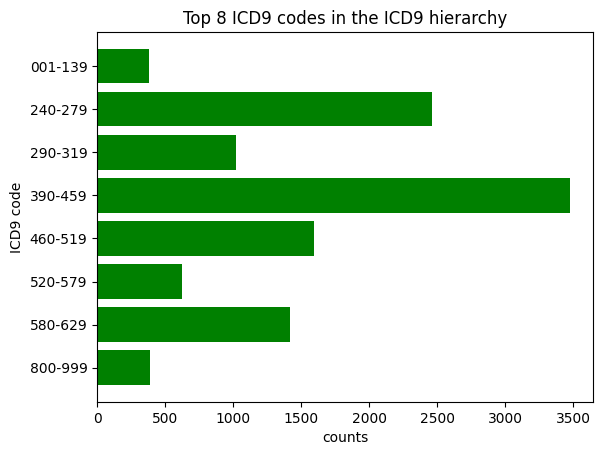

In [16]:
codes_counts =icd9_codes.items()
codes_counts = sorted(codes_counts)
icd9_labels, values = zip(*codes_counts)
indexes = np.arange(len(icd9_labels))
plt.rcdefaults()
fig,ax = plt.subplots()
ax.barh(indexes, values,  align='center', color='green', ecolor='black')
ax.set_yticks(indexes)
ax.set_yticklabels(icd9_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('counts')
ax.set_ylabel('ICD9 code')
ax.set_title('Top ' + str(number_icd9_first_level) + ' ICD9 codes in the ICD9 hierarchy')
plt.show()

In [17]:
def vectorize_icd_string(x, code_list):
    """Takes a string with ICD codes and returns an array of the right of 0/1"""
    r = []
    for code in code_list:
        if code in x: r.append(1)
        else: r.append(0)
    return np.asarray(r)

In [18]:
def vectorize_icd_column(df, col_name, code_list):
    """Takes a column and applies the """
    r = df[col_name].apply(lambda x: vectorize_icd_string(x, code_list))
    r = np.transpose(np.column_stack(r))
    return r


In [19]:
top_codes = ICD9_FIRST_LEVEL
labels = vectorize_icd_column(df_pre, 'ICD9_CODE', top_codes)
print ('sample of vectorized icd9 labels: ', labels[0])

sample of vectorized icd9 labels:  [0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [20]:
def clean_str(string):
    """Cleaning of notes"""

    """ Cleaning from Guillaume """
    string = string.lower()
    string = string.replace("\n", " ") # remove the lines
    string = re.sub("\[\*\*.*?\*\*\]", "", string) # remove the things inside the [** **]
    string = re.sub("[^a-zA-Z0-9\ \']+", " ", string)

    """ Tokenization/string cleaning for all datasets except for SST.
        Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
        """
    #string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    #string = re.sub(r",", " , ", string)
    #string = re.sub(r"!", " ! ", string)
    #string = re.sub(r"\(", " \( ", string)
    #string = re.sub(r"\)", " \) ", string)
    #string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    
    """ Canonize numbers"""
    string = re.sub(r"(\d+)", "DG", string)
    
    return string.strip()


In [21]:
def clean_notes(df, col_name):
    r = df[col_name].apply(lambda x: clean_str(x))
    return r

In [22]:
def vectorize_notes(col, MAX_NB_WORDS, verbose = True):
    """Takes a note column and encodes it into a series of integer
        Also returns the dictionnary mapping the word to the integer"""
    tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
    tokenizer.fit_on_texts(col)
    data = tokenizer.texts_to_sequences(col)
    note_length =  [len(x) for x in data]
    vocab = tokenizer.word_index
    MAX_VOCAB = len(vocab)
    if verbose:
        print('Vocabulary size: %s' % MAX_VOCAB)
        print('Average note length: %s' % np.mean(note_length))
        print('Max note length: %s' % np.max(note_length))
    return data, vocab, MAX_VOCAB

def pad_notes(data, MAX_SEQ_LENGTH):
    data = pad_sequences(data, maxlen = MAX_SEQ_LENGTH)
    return data, data.shape[1]

In [23]:
MAX_VOCAB = None # to limit original number of words (None if no limit)
MAX_SEQ_LENGTH = 5000 # to limit length of word sequence (None if no limit)
df_pre.TEXT = clean_notes(df_pre, 'TEXT')
data_vectorized, dictionary, MAX_VOCAB = vectorize_notes(df_pre.TEXT, MAX_VOCAB, verbose = True)
data, MAX_SEQ_LENGTH = pad_notes(data_vectorized, MAX_SEQ_LENGTH)

print("Final Vocabulary: %s" % MAX_VOCAB)
print("Final Max Sequence Length: %s" % MAX_SEQ_LENGTH)

Vocabulary size: 42144
Average note length: 1631.7412739965096
Max note length: 6348
Final Vocabulary: 42144
Final Max Sequence Length: 5000


In [24]:
df_pre.head(4)

,HADM_ID,CHARTDATE,TEXT,SUBJECT_ID,ICD9_CODE
0,125252.0,2111-06-28,admission date discharge date service vsu chie...,19104,290-319 520-579 240-279 390-459
1,129332.0,2189-06-01,admission date discharge date date of birth se...,87948,520-579 240-279 460-519
2,136164.0,2177-08-01,admission date discharge date date of birth se...,23100,390-459
3,111367.0,2101-06-08,admission date discharge date date of birth se...,56430,240-279 390-459


In [25]:
text_notes = df_pre['TEXT']
text_notes

0       admission date discharge date service vsu chie...
1       admission date discharge date date of birth se...
2       admission date discharge date date of birth se...
3       admission date discharge date date of birth se...
4       admission date discharge date service surgery ...
                              ...                        
4579    admission date discharge date service medicine...
4580    admission date discharge date date of birth se...
4581    admission date discharge date date of birth se...
4582    admission date discharge date date of birth se...
4583    admission date discharge date date of birth se...
Name: TEXT, Length: 4584, dtype: object

In [26]:
# text_notes.to_csv('corpus.txt', sep=' ', index=False)

In [27]:
def embedding_matrix(f_name, dictionary, EMBEDDING_DIM, verbose = True, sigma = None):
    """Takes a pre-trained embedding and adapts it to the dictionary at hand
        Words not found will be all-zeros in the matrix"""

    # Dictionary of words from the pre trained embedding
    pretrained_dict = {}
    with open(f_name, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            pretrained_dict[word] = coefs

    # Default values for absent words
    if sigma:
        pretrained_matrix = sigma * np.random.rand(len(dictionary) + 1, EMBEDDING_DIM)
    else:
        pretrained_matrix = np.zeros((len(dictionary) + 1, EMBEDDING_DIM))
    
    # Substitution of default values by pretrained values when applicable
    for word, i in dictionary.items():
        vector = pretrained_dict.get(word)
        if vector is not None:
            pretrained_matrix[i] = vector

    if verbose:
        print('Vocabulary in notes:', len(dictionary))
        print('Vocabulary in original embedding:', len(pretrained_dict))
        inter = list( set(dictionary.keys()) & set(pretrained_dict.keys()) )
        print('Vocabulary intersection:', len(inter))

    return pretrained_matrix, pretrained_dict

In [28]:
EMBEDDING_DIM = 50 # given the glove that we chose
EMBEDDING_MATRIX= []

In [29]:
#creating glove embeddings
EMBEDDING_LOC = '/content/gdrive/MyDrive/mimic-iii-clinical-database-1.4/vectors.txt' # location of embedding
EMBEDDING_MATRIX, embedding_dict = embedding_matrix(EMBEDDING_LOC,
                                                                  dictionary, EMBEDDING_DIM, verbose = True, sigma=True)

Vocabulary in notes: 42144
Vocabulary in original embedding: 71291
Vocabulary intersection: 14863


In [30]:
from sklearn.model_selection import train_test_split
def train_val_test_split(X, y, val_size=0.2, test_size=0.2, random_state=101):
    """Splits the input and labels into 3 sets"""
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size+test_size), random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(val_size+test_size), random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [31]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    data, labels, val_size=0.2, test_size=0.1, random_state=101)
print("Train: ", X_train.shape, y_train.shape)
print("Validation: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train:  (3208, 5000) (3208, 19)
Validation:  (917, 5000) (917, 19)
Test:  (459, 5000) (459, 19)


Baseline: Predict Top 4

In [32]:
top_4_icd9 = icd9_codes.most_common(4)
print("most common 4 icd9_codes: ", top_4_icd9)
top_4_icd9_label = ' '.join(code for code,count in top_4_icd9 )
print('label for the top 4 icd9 codes: ', top_4_icd9_label)

most common 4 icd9_codes:  [('390-459', 3472), ('240-279', 2463), ('460-519', 1591), ('580-629', 1416)]
label for the top 4 icd9 codes:  390-459 240-279 460-519 580-629


In [33]:
#converting ICD9 prediction to a vector
top4_icd9_vector =  vectorize_icd_string(top_4_icd9_label, ICD9_FIRST_LEVEL)
print(ICD9_FIRST_LEVEL)
print(top4_icd9_vector)

['001-139', '140-239', '240-279', '290-319', '320-389', '390-459', '460-519', '520-579', '580-629', '630-679', '680-709', '710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999']
[0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0]


In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


def train_val_test_split(X, y, val_size=0.2, test_size=0.2, random_state=101):
    """Splits the input and labels into 3 sets"""
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size+test_size), random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(val_size+test_size), random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test


def replace_with_grandparent_codes(string_codes, ICD9_FIRST_LEVEL):
    """replace_with_grandparent_codes takes a list of ICD9 codes and 
    returns the list of their grandparents ICD9 code in the first level of the ICD9 hierarchy"""
    ICD9_RANGES = [x.split('-') for x in ICD9_FIRST_LEVEL]
    resulting_codes = []
    for code in string_codes.split(' '):
        for i,gparent_range in enumerate(ICD9_RANGES):
            range = gparent_range[1] if len(gparent_range) == 2 else gparent_range[0]
            if code[0:3] <= range:
                resulting_codes.append(ICD9_FIRST_LEVEL[i])
                break 
    return ' '.join (set(resulting_codes))


def write_col(df, col_name, fname):
    df[col_name].to_csv(fname)
    

def get_f1_score(y_true,y_hat,threshold, average):
    hot_y = np.where(np.array(y_hat) > threshold, 1, 0)
    return f1_score(np.array(y_true), hot_y, average=average)

def show_f1_score(y_train, pred_train, y_val, pred_dev):
    print('F1 scores')
    print('threshold | training | dev | precision_train | precision_validation | recall_train | recall_validation | accuracy_train | accuracy_val ')
    f1_score_average = 'micro'
    for threshold in [ 0.02, 0.03,0.04,0.05,0.055,0.058,0.06, 0.08, 0.1,0.2,0.3, 0.4, 0.5, 0.6,0.7]:
        train_f1 = get_f1_score(y_train, pred_train,threshold,f1_score_average)
        dev_f1 = get_f1_score(y_val, pred_dev,threshold,f1_score_average)
        precision = precision_score(y_train.flatten().astype('int'), pred_train.flatten().astype('int'), average = f1_score_average)
        precision_val = precision_score(y_val.flatten().astype('int'), pred_dev.flatten().astype('int'), average = f1_score_average)
        recall = recall_score(y_train.flatten().astype('int'), pred_train.flatten().astype('int'), average = f1_score_average)
        recall_val = recall_score(y_val.flatten().astype('int'), pred_dev.flatten().astype('int'), average = f1_score_average)
        accuracy = accuracy_score(y_train.flatten().astype('int'), pred_train.flatten().astype('int'))
        accuracy_val = accuracy_score(y_val.flatten().astype('int'), pred_dev.flatten().astype('int'))
 
        print('%1.3f:      %1.3f      %1.3f      %1.3f      %1.3f      %1.3f      %1.3f      %1.3f      %1.3f' % (threshold,train_f1, dev_f1, precision, precision_val, recall, recall_val, accuracy, accuracy_val))

In [37]:
## assign icd9_prediction_vector to every discharge
train_y_hat_baseline = [top4_icd9_vector]* len (y_train)
dev_y_hat_baseline = [top4_icd9_vector]* len (y_val)
show_f1_score(y_train, train_y_hat_baseline, y_val, dev_y_hat_baseline)


F1 scores
threshold | training | dev | precision_train | precision_validation | recall_train | recall_validation | accuracy_train | accuracy_val 


AttributeError: ignored

LSTM Model

In [38]:
from keras.models import  Model
from keras.layers import Dense, Dropout, Flatten, Input,  Embedding,Bidirectional
from keras.layers.merge import Concatenate
from keras.layers import LSTM
import tensorflow
from tensorflow.keras import optimizers
# Author: Zenobia Liendo
def build_lstm_model(input_seq_length, 
                         max_vocab, external_embeddings, embedding_trainable, embedding_dim, embedding_matrix,
                     training_dropout_keep_prob, num_classes):
    #Embedding
    model_input = Input(shape=(input_seq_length, ))
    if external_embeddings:
        # use embedding_matrix 
        z = Embedding(max_vocab + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=input_seq_length,
                            trainable=embedding_trainable)(model_input)
    else:
        # train embeddings 
        z =  Embedding(max_vocab + 1, 
                   embedding_dim, 
                   input_length=input_seq_length, 
                   name="embedding")(model_input)

    # LSTM
    l_lstm = LSTM(50)(z)
    
    z = Dropout(training_dropout_keep_prob)(l_lstm)
    
    #score prediction 
    model_output = Dense(num_classes, activation="sigmoid")(z)

    #creating model
    model = Model(model_input, model_output)
    # what to use for tf.nn.softmax_cross_entropy_with_logits?
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    #model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    print(model.summary())

    return model

In [39]:
l_model = build_lstm_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = True, embedding_trainable =True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,                             
                             num_classes=N_TOP, training_dropout_keep_prob=0.5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000)]            0         
                                                                 
 embedding (Embedding)       (None, 5000, 50)          2107250   
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 19)                969       
                                                                 
Total params: 2,128,419
Trainable params: 2,128,419
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
df

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...
...,...,...,...,...,...,...,...,...,...,...,...
2083175,2070657,31097,115637.0,2132-01-21,2132-01-21 03:27:00,2132-01-21 03:38:00,Nursing/other,Report,17581.0,NaN,NPN\n\n\n#1 Infant remains in RA with O2 sats...
2083176,2070658,31097,115637.0,2132-01-21,2132-01-21 09:50:00,2132-01-21 09:53:00,Nursing/other,Report,19211.0,NaN,"Neonatology\nDOL #5, CGA 36 weeks.\n\nCVR: Con..."
2083177,2070659,31097,115637.0,2132-01-21,2132-01-21 16:42:00,2132-01-21 16:44:00,Nursing/other,Report,20104.0,NaN,Family Meeting Note\nFamily meeting held with ...
2083178,2070660,31097,115637.0,2132-01-21,2132-01-21 18:05:00,2132-01-21 18:16:00,Nursing/other,Report,16023.0,NaN,NPN 1800\n\n\n#1 Resp: [**Known lastname 2243*...


In [ ]:
len(X_train)

In [41]:
#test with low epochs
l_model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val), verbose=1)


Epoch 1/15
101/101 [==============================] - 430s 4s/step - loss: 0.3473 - accuracy: 0.2846 - val_loss: 0.2176 - val_accuracy: 0.2454
Epoch 2/15
101/101 [==============================] - 430s 4s/step - loss: 0.2408 - accuracy: 0.2678 - val_loss: 0.2116 - val_accuracy: 0.2454
Epoch 3/15
101/101 [==============================] - 430s 4s/step - loss: 0.2290 - accuracy: 0.2671 - val_loss: 0.2079 - val_accuracy: 0.2454
Epoch 4/15
101/101 [==============================] - 431s 4s/step - loss: 0.2219 - accuracy: 0.2656 - val_loss: 0.2063 - val_accuracy: 0.2454
Epoch 5/15
101/101 [==============================] - 432s 4s/step - loss: 0.2192 - accuracy: 0.2581 - val_loss: 0.2053 - val_accuracy: 0.2454
Epoch 6/15
101/101 [==============================] - 434s 4s/step - loss: 0.2151 - accuracy: 0.2544 - val_loss: 0.2035 - val_accuracy: 0.2454
Epoch 7/15
101/101 [==============================] - 432s 4s/step - loss: 0.2114 - accuracy: 0.2466 - val_loss: 0.2013 - val_accuracy: 0.2432

In [ ]:
len(X_train)

In [ ]:
# l_model.fit(X_train, y_train, batch_size=50, epochs=5, validation_data=(X_val, y_val), verbose=1)

In [42]:
pred_train = l_model.predict(X_train, batch_size=100)
pred_dev = l_model.predict(X_val, batch_size=100)
show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev | precision_train | precision_validation | recall_train | recall_validation | accuracy_train | accuracy_val 
0.020:      0.526      0.532      0.870      0.868      0.870      0.868      0.870      0.868
0.030:      0.532      0.537      0.870      0.868      0.870      0.868      0.870      0.868
0.040:      0.539      0.543      0.870      0.868      0.870      0.868      0.870      0.868
0.050:      0.551      0.551      0.870      0.868      0.870      0.868      0.870      0.868
0.055:      0.556      0.555      0.870      0.868      0.870      0.868      0.870      0.868
0.058:      0.560      0.557      0.870      0.868      0.870      0.868      0.870      0.868
0.060:      0.562      0.559      0.870      0.868      0.870      0.868      0.870      0.868
0.080:      0.576      0.567      0.870      0.868      0.870      0.868      0.870      0.868
0.100:      0.593      0.580      0.870      0.868      0.870      0.868      0.870      0.868

CNN Model

In [ ]:
def build_icd9_cnn_model(input_seq_length, 
                         max_vocab, external_embeddings, embedding_dim, embedding_matrix,
                         num_filters, filter_sizes,
                         training_dropout_keep_prob,
                         num_classes):
    #Embedding
    model_input = Input(shape=(input_seq_length, ))
    if external_embeddings:
        # use embedding_matrix 
        z = Embedding(max_vocab + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=input_seq_length,
                            trainable=True)(model_input)
    else:
        # train embeddings 
        z =  Embedding(max_vocab + 1, 
                   embedding_dim, 
                   input_length=input_seq_length, embeddings_regularizer=regularizers.l2(0.0001),
                   name="embedding")(model_input)

    # Convolutional block
    conv_blocks = []
    for sz in filter_sizes:
        conv = Convolution1D(filters=num_filters,                         
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
        window_pool_size =  input_seq_length  - sz + 1 
        conv = MaxPooling1D(pool_size=window_pool_size)(conv)  
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    #concatenate
    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dropout(training_dropout_keep_prob)(z)

    #score prediction
    model_output = Dense(num_classes, activation="sigmoid")(z)

    #creating model
    model = Model(model_input, model_output)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    print(model.summary())

    return model

In [ ]:
model = build_icd9_cnn_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = False,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,
                             num_filters = 100, filter_sizes=[2,3,4,5],
                             training_dropout_keep_prob=0.5,
                             num_classes=N_TOP )

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 5000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5000, 50)     2108400     ['input_4[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 4999, 100)    10100       ['embedding[0][0]']              
                                                                                                  
 conv1d_5 (Conv1D)              (None, 4998, 100)    15100       ['embedding[0][0]']              
                                                                                            

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val), verbose=2)

Epoch 1/15
101/101 - 117s - loss: 0.3332 - accuracy: 0.2357 - val_loss: 0.2166 - val_accuracy: 0.2345 - 117s/epoch - 1s/step
Epoch 2/15
101/101 - 118s - loss: 0.2165 - accuracy: 0.2469 - val_loss: 0.2055 - val_accuracy: 0.2345 - 118s/epoch - 1s/step
Epoch 3/15
101/101 - 115s - loss: 0.2078 - accuracy: 0.2516 - val_loss: 0.2000 - val_accuracy: 0.2345 - 115s/epoch - 1s/step
Epoch 4/15
101/101 - 119s - loss: 0.2017 - accuracy: 0.2553 - val_loss: 0.1926 - val_accuracy: 0.2497 - 119s/epoch - 1s/step
Epoch 5/15
101/101 - 112s - loss: 0.1940 - accuracy: 0.2612 - val_loss: 0.1875 - val_accuracy: 0.2585 - 112s/epoch - 1s/step
Epoch 6/15
101/101 - 111s - loss: 0.1884 - accuracy: 0.2693 - val_loss: 0.1835 - val_accuracy: 0.2563 - 111s/epoch - 1s/step
Epoch 7/15
101/101 - 112s - loss: 0.1841 - accuracy: 0.2862 - val_loss: 0.1793 - val_accuracy: 0.2814 - 112s/epoch - 1s/step
Epoch 8/15
101/101 - 111s - loss: 0.1798 - accuracy: 0.3117 - val_loss: 0.1753 - val_accuracy: 0.3217 - 111s/epoch - 1s/step


In [ ]:
pred_train = model.predict(X_train, batch_size=50)
pred_dev = model.predict(X_val, batch_size=50)
# perform evaluation
show_f1_score(y_train, pred_train, y_val, pred_dev)

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev | precision_train | precision_validation | recall_train | recall_validation | accuracy_train | accuracy_val 
0.020:      0.520      0.505      0.868      0.871      0.868      0.871      0.868      0.871
0.030:      0.538      0.523      0.868      0.871      0.868      0.871      0.868      0.871
0.040:      0.555      0.539      0.868      0.871      0.868      0.871      0.868      0.871
0.050:      0.570      0.552      0.868      0.871      0.868      0.871      0.868      0.871
0.055:      0.577      0.557      0.868      0.871      0.868      0.871      0.868      0.871
0.058:      0.581      0.561      0.868      0.871      0.868      0.871      0.868      0.871
0.060:      0.584      0.564      0.868      0.871      0.868      0.871      0.868      0.871
0.080:      0.617      0.594      0.868      0.871      0.868      0.871      0.868      0.871
0.100:      0.649      0.624      0.868      0.871      0.868      0.871      0.868      0.871

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_train.astype('int'), pred_train.astype('int'), average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [ ]:
y_train.shape, y_train.flatten().shape

((3208, 19), (60952,))

In [ ]:
y_train.astype('int')

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])